# Dual Linear Regression 

## Step 1: Read in data and convert to pyspark DF

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
import pandas as pd
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from pyspark.sql import SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import substring, length, expr
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import operator
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt

num_of_val=500

df=pd.read_csv('word_rating.csv')
df=df.dropna(subset=['Rating'])

print(df)


     Rank                                            Title          Company  \
0       7                                           Onward      Walt Disney   
1       3                                    Birds of Prey     Warner Bros.   
2       2                               Sonic The Hedgehog  ParamountÃ¯Â¿Â½   
3       4                                         Dolittle        Universal   
4       6                             The Call of the Wild  20th CentÃ¯Â¿Â½   
..    ...                                              ...              ...   
142   113                                       Jiang Ziya      Well Go USA   
143   108  Created Equal: Clarence Thomas in His Own Words  Manifold Ã¯Â¿Â½   
144   151                Pray: The Story of Patrick Peyton       ArtAffects   
145    67                                            Becky           Quiver   
147   227                                          Kindred     IFC Midnight   

        DomBox      OpWeek  maxthe  \
0     6155514

In [3]:
spark = SparkSession \
.builder \
.appName("Project") \
.getOrCreate()

sparkDF=spark.createDataFrame(df.astype(str)) 
sparkDF.printSchema()
sparkDF.select('word rating').show()
sparkDF.select('Rating').show()

root
 |-- Rank: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- DomBox: string (nullable = true)
 |-- OpWeek: string (nullable = true)
 |-- maxthe: string (nullable = true)
 |-- YT_codes: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- yt comments: string (nullable = true)
 |-- word rating: string (nullable = true)

+--------------------+
|         word rating|
+--------------------+
|[-2, 2, 2, 2, 1, ...|
|[2, -3, 3, 4, -3,...|
|[2, 3, -1, 3, 3, ...|
|[-1, 1, -4, -3, 1...|
|[1, -4, -1, 4, 2,...|
|[-3, -4, -1, -4, ...|
|[-2, 2, 4, 2, 4, ...|
|[-3, 2, 3, 2, -2,...|
|[2, 1, 1, 3, 4, -...|
|[2, 2, 4, 4, -1, ...|
|[4, 2, 3, 3, 3, 3...|
|[4, 3, 1, 2, 3, -...|
|[3, 1, -2, 3, 3, ...|
|[2, 1, 4, 3, 2, -...|
|[-2, 1, 2, 3, 3, ...|
|[-3, 3, -1, 1, -2...|
|[3, -3, 3, 3, 3, ...|
|[-3, -1, 2, 2, 2,...|
|[-2, 4, 1, 3, 4, ...|
|[2, 3, 2, 2, 2, 1...|
+--------------------+
only showing top 20 rows

+------+
|Rating|
+------+

## Step 2: Reformat string Function to Dense Vectors and filter lengths<500

In [4]:
def Reformat_data(input_df,learning):
    sqlContext = SQLContext(spark)
    
    if learning:
        ML_df=input_df.select('Rating','word rating','Title','DomBox')
        ML_df.show()
        ML_df = ML_df.select(col("Rating").alias("label"), col("word rating").alias("features"),col("Title").alias("Title"),col("DomBox").alias("DomBox"))
        ML_df = ML_df.withColumn("features",expr("substring(features, 2, length(features)-2)"))

        feat_array = [[row.features] for row in ML_df.collect()]
        rating_array = [row.label for row in ML_df.collect()]
        title_array = [row.Title for row in ML_df.collect()]
        dom_array = [row.DomBox for row in ML_df.collect()]
    else:
        ML_df=input_df.select('word rating','Title')
        ML_df.show()
        ML_df = ML_df.select(col("word rating").alias("features"),col("Title").alias("Title"))
        ML_df = ML_df.withColumn("features",expr("substring(features, 2, length(features)-2)"))

        feat_array = [[row.features] for row in ML_df.collect()]
        title_array = [row.Title for row in ML_df.collect()]

    val_tot=[]
    total_num=0
    ind=0
    len_lst=[]

    for group in feat_array:
        x=0
        val_lst=group[0].split(', ')
        val_sec=[]
        for item in val_lst:
            try:
                int_val=int(item)
            except Exception as e:
                print(e)
                print(item)  
            if x==num_of_val:
                break
            else:
                val_sec.append(int_val)
                x=x+1
        len_lst.append(len(val_sec))
        total_num=total_num+len(val_sec) 
        val_tot.append(Vectors.dense(val_sec))

    av_tot=total_num/len(val_tot)
    print(av_tot)

    if learning:
        final_df=sqlContext.createDataFrame(zip(rating_array, val_tot,title_array,len_lst,dom_array), schema=['label', 'features','Title','lengths','DomBox'])
        final_df = final_df.withColumn("label", final_df["label"].cast(FloatType()))
        final_df.show()
    else:
        final_df=sqlContext.createDataFrame(zip(val_tot,title_array,len_lst), schema=['features','Title','lengths'])
        final_df.show()    
        
    return(final_df)



In [5]:
final_df=Reformat_data(sparkDF,True)
filt_df=final_df.filter(final_df.lengths == num_of_val)
filt_df.show()
print(filt_df.count())

+------+--------------------+--------------------+---------+
|Rating|         word rating|               Title|   DomBox|
+------+--------------------+--------------------+---------+
|  95.0|[-2, 2, 2, 2, 1, ...|              Onward| 61555145|
|  78.0|[2, -3, 3, 4, -3,...|       Birds of Prey| 84158461|
|  93.0|[2, 3, -1, 3, 3, ...|  Sonic The Hedgehog|146066470|
|  76.0|[-1, 1, -4, -3, 1...|            Dolittle| 77047065|
|  89.0|[1, -4, -1, 4, 2,...|The Call of the Wild| 62342368|
|  96.0|[-3, -4, -1, -4, ...|   Bad Boys For Life|204417855|
|  88.0|[-2, 2, 4, 2, 4, ...|   The Invisible Man| 64914050|
|  98.0|[-3, 2, 3, 2, -2,...|     I Still Believe| 10410004|
|  65.0|[2, 1, 1, 3, 4, -...|         Like a Boss| 22169514|
|  44.0|[2, 2, 4, 4, -1, ...|  The Rhythm Section|  5437971|
|  66.0|[4, 2, 3, 3, 3, 3...|            The Hunt|  5812500|
|  23.0|[4, 3, 1, 2, 3, -...|     Gretel & Hansel| 15347654|
|  76.0|[3, 1, -2, 3, 3, ...|               Tenet| 57929000|
|  78.0|[2, 1, 4, 3, 2, 

## Step 3: Split data into training/test sets (70%,30%) and train Model1

In [6]:
splData=filt_df.randomSplit([0.7,0.3], 100)
trainingData1=splData[0]
testData1=splData[1]

#===============================
print("Total Data Set count:")
print(filt_df.count())

print("Training Data:")
print(trainingData1.count())
print("Test Data:")
print(testData1.count())

if (trainingData1.count()+testData1.count())==filt_df.count():
    print("Data count verified:")
    print("total data=",str(trainingData1.count()+testData1.count()))
else:
    print("Data totals do not match")

Total Data Set count:
91
Training Data:
63
Test Data:
28
Data count verified:
total data= 91


In [7]:
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model1 = lr.fit(trainingData1)
print("Coefficients: " + str(lr_model1.coefficients))
print("Intercept: " + str(lr_model1.intercept))

Coefficients: [0.0,0.0,0.0,0.21195644852220893,0.0,0.002961374239289025,0.0,0.0,0.0,0.0,0.0,-0.46414559549118867,0.0025977225224343703,0.0,-0.1183550291601376,0.08747896973183335,0.0,-0.11015931716007271,0.006755396819728564,0.0,0.0,0.0,0.31998680488533426,0.7817513459552528,0.20390547312001223,0.0,0.0,0.0,-0.21893467782054127,0.0,0.2810630115838935,0.0,0.0,0.0,0.0,0.0,0.037679225839781526,0.05859407463211344,0.0,0.0,0.5128996097969244,0.011725394392191215,0.0,0.0,0.0,-0.021126878188145792,0.0,0.0,-0.0011558878840641346,0.2658059073206467,0.0,-0.1328166189065136,0.0,0.0,0.0,0.0,0.0,0.0,-0.12911747164331958,0.0,-0.7219606954831551,0.0,-0.6061313174228306,0.0,0.0,0.0,0.0,0.09793040785509856,0.0,-0.5245534164372396,0.35024169526923854,-0.0,0.0,0.09311805028279391,-0.10774837423829259,0.04299283548186753,0.16996317546381673,0.0013214222979732522,-0.09956899712421849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16323793640098155,0.05320780034721791,0.0,0.0,0.18703607083520798,-0.00

## Step 4: Calculate residuals and deviation Metrics

In [8]:
trainingSummary = lr_model1.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.328074
r2: 0.995431


In [9]:
trainingData1.describe().show()

+-------+------------------+--------+-------+--------------------+
|summary|             label|   Title|lengths|              DomBox|
+-------+------------------+--------+-------+--------------------+
|  count|                63|      63|     63|                  63|
|   mean| 69.06349206349206|    null|  500.0|1.3383981015873017E7|
| stddev|19.804588109563202|    null|    0.0|2.4982145471047524E7|
|    min|              20.0|2 Hearts|    500|             1002852|
|    max|              98.0|   Zappa|    500|             9358025|
+-------+------------------+--------+-------+--------------------+



In [10]:
lr_predictions = lr_model1.transform(testData1)
lr_predictions.select("prediction","label","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 74.60602192643051| 56.0|[3.0,-3.0,3.0,3.0...|
| 69.81175466874525| 78.0|[2.0,1.0,4.0,3.0,...|
| 74.75981743592143| 88.0|[-2.0,2.0,4.0,2.0...|
| 75.30100577550004| 95.0|[-2.0,2.0,2.0,2.0...|
|58.998379712914435| 96.0|[-3.0,-4.0,-1.0,-...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.0136662


In [11]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5, 0.36555604726478486, 0.10830148943976953, 0.08030323412796274, 0.06623380523187665, 0.06253006289755549, 0.0582996190075667, 0.055096345590102756, 0.052855258319035564, 0.05111209174053825, 0.05037353843328472]
+--------------------+
|           residuals|
+--------------------+
| -2.5270192273717136|
| -0.8366951853631335|
|  0.6328943817483363|
| -0.8668056638829285|
|  0.2895011505584506|
| -0.7861763841745812|
|  0.7048797970265639|
| -0.9176684216141666|
| 0.19025255375622407|
|  0.5133725669739562|
|  2.5274433328184216|
|  1.0152745514043602|
| -3.3200817288466418|
| -0.6561160607039227|
| -0.5041408609029077|
|  1.1758962385827871|
|  0.7838694680353342|
|  -2.684690370656341|
|-0.22241603283853806|
| -1.3245333719636676|
+--------------------+
only showing top 20 rows



## Step 5: Calculate predictions on test data (Rotten Tomato Rank) 

In [12]:
predictions = lr_model1.transform(testData1)
predictions.select("prediction","label","features",'Title').show()

+------------------+-----+--------------------+--------------------+
|        prediction|label|            features|               Title|
+------------------+-----+--------------------+--------------------+
| 74.60602192643051| 56.0|[3.0,-3.0,3.0,3.0...|     The New Mutants|
| 69.81175466874525| 78.0|[2.0,1.0,4.0,3.0,...|           Bloodshot|
| 74.75981743592143| 88.0|[-2.0,2.0,4.0,2.0...|   The Invisible Man|
| 75.30100577550004| 95.0|[-2.0,2.0,2.0,2.0...|              Onward|
|58.998379712914435| 96.0|[-3.0,-4.0,-1.0,-...|   Bad Boys For Life|
| 79.21925696299927| 60.0|[-4.0,2.0,-2.0,-2...|      The Photograph|
|58.440992321456754| 60.0|[1.0,-2.0,3.0,3.0...|            Downhill|
| 70.37486402107528| 88.0|[-1.0,2.0,3.0,4.0...|The Broken Hearts...|
|  76.1116250501783| 94.0|[3.0,4.0,3.0,3.0,...|The Croods: A New...|
| 61.62190000918405| 55.0|[2.0,3.0,2.0,2.0,...|The Personal Hist...|
| 77.68494527816905| 66.0|[-3.0,3.0,4.0,3.0...|Bill & Ted Face t...|
| 73.90134368128857| 72.0|[2.0,1.0

In [13]:
pred_lst1=list(predictions.select('prediction').toPandas()['prediction'])
lab_lst1=list(predictions.select('label').toPandas()['label'])
title_lst1=list(predictions.select('Title').toPandas()['Title'])
print(pred_lst1)
print(lab_lst1)
print(list(map(operator.sub, pred_lst1, lab_lst1)))

[74.60602192643051, 69.81175466874525, 74.75981743592143, 75.30100577550004, 58.998379712914435, 79.21925696299927, 58.440992321456754, 70.37486402107528, 76.1116250501783, 61.62190000918405, 77.68494527816905, 73.90134368128857, 64.48140002664056, 66.8742658021221, 52.719112397269804, 75.59051990058572, 65.87041948820058, 55.336333189722474, 64.97700126752079, 71.34219583069006, 63.60911563245616, 52.35437517376961, 66.78568202002155, 76.0572387608167, 48.7622988718697, 64.39938063835562, 64.16260861180781, 82.00911094928247]
[56.0, 78.0, 88.0, 95.0, 96.0, 60.0, 60.0, 88.0, 94.0, 55.0, 66.0, 72.0, 76.0, 30.0, 39.0, 51.0, 93.0, 72.0, 76.0, 89.0, 55.0, 32.0, 43.0, 82.0, 85.0, 97.0, 69.0, 89.0]
[18.606021926430515, -8.188245331254748, -13.240182564078566, -19.698994224499955, -37.001620287085565, 19.219256962999268, -1.5590076785432458, -17.625135978924718, -17.888374949821696, 6.621900009184053, 11.684945278169053, 1.9013436812885658, -11.518599973359443, 36.874265802122096, 13.71911239

## Step 6: Repeat formatting for second (Box Office Gross sales) Model

In [14]:
filt_df2 = filt_df.select(col("label").alias("Rating"), col("features").alias("word rating"), col("Title").alias("Title"))

vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["Rating", "word rating"])

form2df=vecAssembler.transform(filt_df2).drop("Rating","word rating")
ML_df2=filt_df.select('DomBox','Title')

form2df.show()
ML_df2.show()

final2df = form2df.join(ML_df2, on=['Title'], how='right')
final2df = final2df.select(col("DomBox").alias("label"), col("features").alias("features"), col("Title").alias("Title"))
final2df = final2df.withColumn("label", final2df["label"].cast(FloatType()))

final2df.show()
print(final2df.count())

+--------------------+--------------------+
|               Title|            features|
+--------------------+--------------------+
|              Onward|[95.0,-2.0,2.0,2....|
|       Birds of Prey|[78.0,2.0,-3.0,3....|
|  Sonic The Hedgehog|[93.0,2.0,3.0,-1....|
|            Dolittle|[76.0,-1.0,1.0,-4...|
|The Call of the Wild|[89.0,1.0,-4.0,-1...|
|   Bad Boys For Life|[96.0,-3.0,-4.0,-...|
|   The Invisible Man|[88.0,-2.0,2.0,4....|
|     I Still Believe|[98.0,-3.0,2.0,3....|
|         Like a Boss|[65.0,2.0,1.0,1.0...|
|  The Rhythm Section|[44.0,2.0,2.0,4.0...|
|            The Hunt|[66.0,4.0,2.0,3.0...|
|     Gretel & Hansel|[23.0,4.0,3.0,1.0...|
|               Tenet|[76.0,3.0,1.0,-2....|
|           Bloodshot|[78.0,2.0,1.0,4.0...|
|          Underwater|[60.0,-2.0,1.0,2....|
|      Fantasy Island|[48.0,-3.0,3.0,-1...|
|     The New Mutants|[56.0,3.0,-3.0,3....|
|        The Way Back|[72.0,-3.0,-1.0,2...|
|       The Gentlemen|[84.0,-2.0,4.0,1....|
|          The Grudge|[46.0,2.0,

## Step 7: Split data into training/test sets (70%,30%) and train Model2

In [15]:
splData=final2df.randomSplit([0.7,0.3], 100)
trainingData2=splData[0]
testData2=splData[1]

#===============================
print("Total Data Set count:")
print(filt_df.count())

print("Training Data:")
print(trainingData2.count())
print("Test Data:")
print(testData2.count())

if (trainingData2.count()+testData2.count())==filt_df.count():
    print("Data count verified:")
    print("total data=",str(trainingData2.count()+testData2.count()))
else:
    print("Data totals do not match")

Total Data Set count:
91
Training Data:
70
Test Data:
21
Data count verified:
total data= 91


In [16]:
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model2 = lr.fit(trainingData2)
print("Coefficients: " + str(lr_model2.coefficients))
print("Intercept: " + str(lr_model2.intercept))

Coefficients: [45979.81216066828,-211503.00708489228,-91236.52003760087,-240019.72466946824,63924.89130178383,288485.57579074503,325530.1022851031,-770031.5149837106,78621.75128802485,-81061.39056750775,-46679.853057188404,276761.04215864354,325847.15127861395,259731.95256764189,271.05428847926,286440.9706466124,288067.6673394615,-113029.61604141178,250977.82746733015,20187.571056104392,128211.00294570974,-604690.0080486336,-17935.470761160872,-43153.78475546892,-421074.81399744324,124385.61082528754,511298.5705069489,266189.7670235544,60796.252909100374,7296.5985869040405,-96415.87093937577,-15057.109935279403,-278062.6632795233,-82268.4596756917,244024.07131821135,28885.36447903494,-124962.19332954458,28023.914217125104,82054.25998654964,379419.4626482948,396860.3871464302,-276142.6188050773,135476.36287310772,-30826.13246038531,-406049.2572593881,-133860.40670531488,-771516.1687781967,38333.71272375835,66602.17287002591,-63983.21751364527,-12994.818720438632,217747.87109615345,1997.

## Step 8: Calculate residuals and deviation Metrics Model 2

In [17]:
trainingSummary = lr_model2.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
trainingSummary = lr_model2.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
RMSE: 1.352042
r2: 0.994796
trainingData2.describe().show()

RMSE: 90599.103627
r2: 0.999993
RMSE: 90599.103627
r2: 0.999993
+-------+--------------------+--------+
|summary|               label|   Title|
+-------+--------------------+--------+
|  count|                  70|      70|
|   mean|1.5253486471428571E7|    null|
| stddev| 3.336347660023662E7|    null|
|    min|             10128.0|2 Hearts|
|    max|        2.04417856E8|   Zappa|
+-------+--------------------+--------+



In [18]:
lr_predictions = lr_model2.transform(testData2)
lr_predictions.select("prediction","label","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-------------------+-----------+--------------------+
|         prediction|      label|            features|
+-------------------+-----------+--------------------+
|1.866739110419118E7|1.0410004E7|[98.0,-3.0,2.0,3....|
|3.636712763841352E7|6.2342368E7|[89.0,1.0,-4.0,-1...|
|  -636192.056470477|7.7047064E7|[76.0,-1.0,1.0,-4...|
|-3148717.9014304914| 1.047599E7|[67.0,-1.0,-1.0,1...|
|  2.1970000137141E7|  1047083.0|[50.0,-3.0,-3.0,3...|
+-------------------+-----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = -0.431655


In [19]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5, 0.36541064483268815, 0.107041523126615, 0.03206171149042143, 0.009594115882163343, 0.0032525604960537955, 0.001072333541784958, 0.0003095094941791269, 7.86256286138694e-05, 1.4925515090541878e-05, 3.7891280441924844e-06]
+-------------------+
|          residuals|
+-------------------+
|  25583.77537307795|
| 56346.625231018756|
| 14091.457491189241|
| -8254.315123595297|
| 130389.97779069887|
|  -15750.6799376118|
| 105096.89047868876|
|-44952.809284280986|
|  64283.93267441541|
|  41817.85037984699|
| 2283.7133692172356|
| -9121.962307088077|
|-28758.995333492756|
|-3826.8523276112974|
| -111330.1239901185|
|  39953.68614985375|
|-5430.9063947531395|
| -54104.31809851574|
|  38250.84743770957|
|   80621.4686780721|
+-------------------+
only showing top 20 rows



## Step 9: Calculate predictions on test data (Gross Domestic Box offfice Sales) 

In [20]:
predictions = lr_model2.transform(testData2)
predictions.select("prediction","label","features",'Title').show()

+--------------------+-----------+--------------------+--------------------+
|          prediction|      label|            features|               Title|
+--------------------+-----------+--------------------+--------------------+
| 1.866739110419118E7|1.0410004E7|[98.0,-3.0,2.0,3....|     I Still Believe|
| 3.636712763841352E7|6.2342368E7|[89.0,1.0,-4.0,-1...|The Call of the Wild|
|   -636192.056470477|7.7047064E7|[76.0,-1.0,1.0,-4...|            Dolittle|
| -3148717.9014304914| 1.047599E7|[67.0,-1.0,-1.0,1...|           Come Play|
|   2.1970000137141E7|  1047083.0|[50.0,-3.0,-3.0,3...|               Relic|
| 1.902196259860054E7|1.7291078E7|[60.0,-2.0,1.0,2....|          Underwater|
| 1.272964954090374E7|   497747.0|[72.0,-2.0,3.0,-2...|                 Ava|
|1.1767358277137164E7| 1.510479E7|[70.0,-3.0,-2.0,1...|      Monster Hunter|
|1.0701274692342091E7|   752885.0|[59.0,-2.0,-3.0,4...|           Possessor|
|-1.02720790359456...|  1002852.0|[56.0,3.0,-1.0,1....|               Becky|

In [21]:
pred_lst2=list(predictions.select('prediction').toPandas()['prediction'])
lab_lst2=list(predictions.select('label').toPandas()['label'])
title_lst2=list(predictions.select('Title').toPandas()['Title'])

print(pred_lst2)
print(lab_lst2)
print(list(map(operator.sub, pred_lst2, lab_lst2)))

#reformat Box office 
lab_lst2=[x/1000000 for x in lab_lst2]
pred_lst2=[x/1000000 for x in pred_lst2]    

[18667391.10419118, 36367127.63841352, -636192.056470477, -3148717.9014304914, 21970000.137141, 19021962.59860054, 12729649.54090374, 11767358.277137164, 10701274.692342091, -10272079.035945669, 44954729.901273705, 3979931.05040631, 7597028.3165839445, 3138756.336421937, 48589866.93619771, 22075152.81417085, 22773378.17669618, 11822890.581797283, 3145952.486899575, 5501269.201526525, 3081031.4982098886]
[10410004.0, 62342368.0, 77047064.0, 10475990.0, 1047083.0, 17291078.0, 497747.0, 15104790.0, 752885.0, 1002852.0, 21277892.0, 5437971.0, 636673.0, 9358025.0, 1070714.0, 139270.0, 9030855.0, 1044212.0, 7798703.0, 15472775.0, 531430.0]
[8257387.10419118, -25975240.36158648, -77683256.05647048, -13624707.901430491, 20922917.137141, 1730884.5986005403, 12231902.54090374, -3337431.722862836, 9948389.692342091, -11274931.035945669, 23676837.901273705, -1458039.9495936902, 6960355.3165839445, -6219268.663578063, 47519152.93619771, 21935882.81417085, 13742523.176696181, 10778678.581797283, -46

## Step 10: Graph visuals for Both Predictions

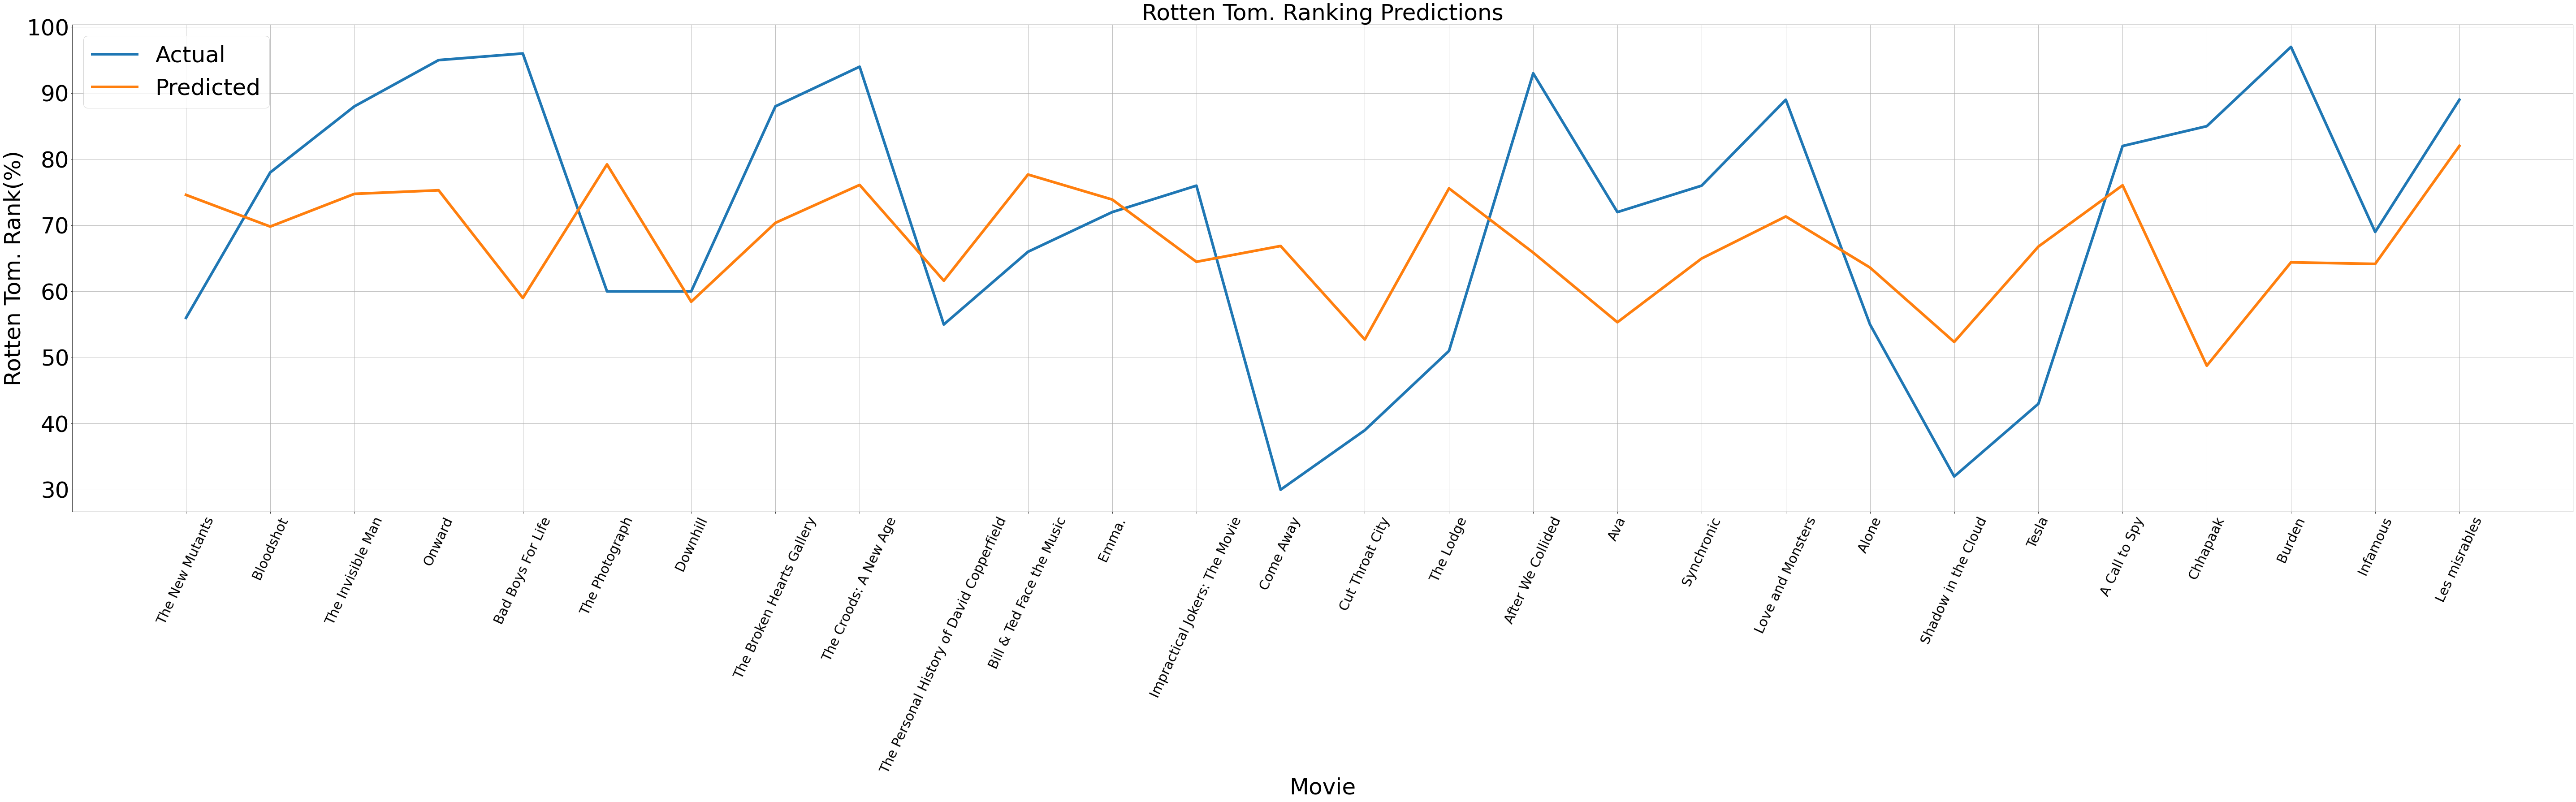

In [22]:
# plot lines
f = plt.figure()
f.set_figwidth(100)
f.set_figheight(20)

plt.plot(title_lst1, lab_lst1, label = "Actual",linewidth=6)
plt.plot(title_lst1, pred_lst1, label = "Predicted",linewidth=6)
plt.legend(loc=2,prop={'size': 50})
plt.title('Rotten Tom. Ranking Predictions',fontsize=50)
plt.xlabel('Movie',fontsize=50)
plt.ylabel('Rotten Tom. Rank(%)',fontsize=50)
plt.xticks(fontsize=30,rotation=65)
plt.yticks(fontsize=50)
plt.grid()
plt.show()

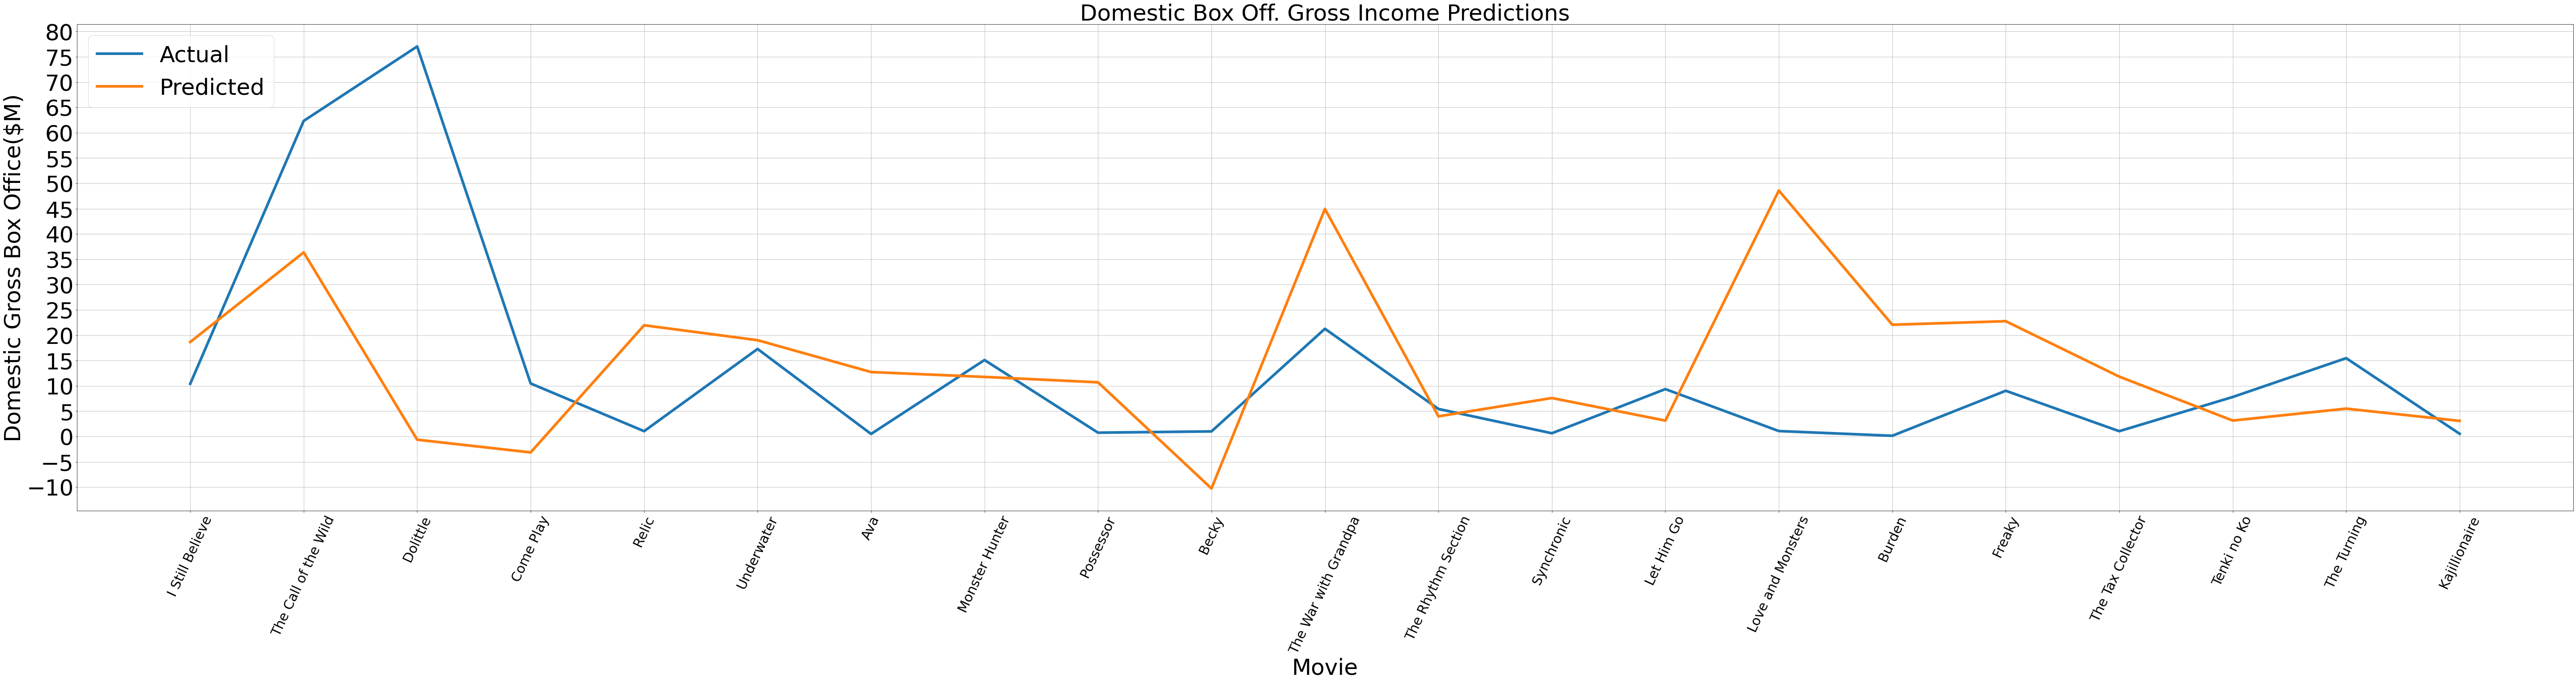

In [23]:
# plot lines
f = plt.figure()
f.set_figwidth(100)
f.set_figheight(20)

plt.plot(title_lst2, lab_lst2, label = "Actual",linewidth=6)
plt.plot(title_lst2, pred_lst2, label = "Predicted",linewidth=6)
plt.legend(loc=2,prop={'size': 50})
plt.title('Domestic Box Off. Gross Income Predictions',fontsize=50)
plt.xlabel('Movie',fontsize=50)
plt.ylabel('Domestic Gross Box Office($M)',fontsize=50)
plt.xticks(fontsize=30,rotation=65)
plt.yticks(fontsize=50)
plt.grid()
plt.locator_params(tight=True,axis="y", nbins=30)
plt.show()


## Step 11: Format 2022 Youtube Data

In [24]:
bad_2022_df=pd.read_csv('bad_word_rating.csv')
good_2022_df=pd.read_csv('good_word_rating.csv')

bad_sparkDF=spark.createDataFrame(bad_2022_df.astype(str)) 
bad_sparkDF.printSchema()
bad_sparkDF.select('word rating').show()


good_sparkDF=spark.createDataFrame(good_2022_df.astype(str)) 
good_sparkDF.printSchema()
good_sparkDF.select('word rating').show()


root
 |-- Title: string (nullable = true)
 |-- YT_codes: string (nullable = true)
 |-- yt comments: string (nullable = true)
 |-- word rating: string (nullable = true)

+--------------------+
|         word rating|
+--------------------+
|[-1, 2, 3, -2, 1,...|
|[-2, 3, 2, 2, 2, ...|
|[4, -1, 3, -3, 3,...|
|[2, 4, -3, 3, 1, ...|
|[1, -1, 1, -2, 3,...|
|[3, -2, 2, -3, 2,...|
|[2, 2, 3, -2, 4, ...|
|[3, 3, 2, 3, 2, 4...|
|[-3, 2, 2, 4, 1, ...|
|[4, 3, 3, 2, -1, ...|
+--------------------+

root
 |-- Title: string (nullable = true)
 |-- YT_codes: string (nullable = true)
 |-- yt comments: string (nullable = true)
 |-- word rating: string (nullable = true)

+--------------------+
|         word rating|
+--------------------+
|[4, 2, -3, 3, 2, ...|
|[3, 2, 3, -2, 3, ...|
|[3, 3, 4, 2, -2, ...|
|[-4, 3, 3, 3, 3, ...|
|[1, 3, -2, 3, 3, ...|
|[3, 4, 3, 1, 3, 2...|
|[4, -1, 4, 3, 2, ...|
|[1, -2, 1, 4, 2, ...|
|[2, 3, -2, 2, 2, ...|
|[3, -3, -3, 3, 3,...|
+--------------------+



In [25]:
final_df=Reformat_data(bad_sparkDF,False)
bad_filt_df=final_df.filter(final_df.lengths == num_of_val)
bad_filt_df.show()
print(bad_filt_df.count())

+--------------------+--------------------+
|         word rating|               Title|
+--------------------+--------------------+
|[-1, 2, 3, -2, 1,...|  HeÃ¢ÂÂs All That|
|[-2, 3, 2, 2, 2, ...|    The Tomorrow War|
|[4, -1, 3, -3, 3,...|          Cinderella|
|[2, 4, -3, 3, 1, ...|         Locked Down|
|[1, -1, 1, -2, 3,...|The Woman in the ...|
|[3, -2, 2, -3, 2,...|            Vanquish|
|[2, 2, 3, -2, 4, ...|Space Jam Ã¢ÂÂ ...|
|[3, 3, 2, 3, 2, 4...|       Thunder Force|
|[-3, 2, 2, 4, 1, ...|       Mortal Kombat|
|[4, 3, 3, 2, -1, ...| The Kissing Booth 3|
+--------------------+--------------------+

500.0
+--------------------+--------------------+-------+
|            features|               Title|lengths|
+--------------------+--------------------+-------+
|[-1.0,2.0,3.0,-2....|  HeÃ¢ÂÂs All That|    500|
|[-2.0,3.0,2.0,2.0...|    The Tomorrow War|    500|
|[4.0,-1.0,3.0,-3....|          Cinderella|    500|
|[2.0,4.0,-3.0,3.0...|         Locked Down|    500|
|[1.0,-1.0,1.

In [26]:
final_df=Reformat_data(good_sparkDF,False)
good_filt_df=final_df.filter(final_df.lengths == num_of_val)
good_filt_df.show()
print(good_filt_df.count())

+--------------------+--------------------+
|         word rating|               Title|
+--------------------+--------------------+
|[4, 2, -3, 3, 2, ...|              Rumble|
|[3, 2, 3, -2, 3, ...|Sonic the Hedgehog 2|
|[3, 3, 4, 2, -2, ...|John Wick: Chapter 4|
|[-4, 3, 3, 3, 3, ...|Jurassic World Do...|
|[1, 3, -2, 3, 3, ...|Minions: The Rise...|
|[3, 4, 3, 1, 3, 2...|Thor: Love and Th...|
|[4, -1, 4, 3, 2, ...|Fantastic Beasts:...|
|[1, -2, 1, 4, 2, ...|            Avatar 2|
|[2, 3, -2, 2, 2, ...|Spider-Man: Into ...|
|[3, -3, -3, 3, 3,...|Ant-Man and The W...|
+--------------------+--------------------+

439.0
+--------------------+--------------------+-------+
|            features|               Title|lengths|
+--------------------+--------------------+-------+
|[4.0,2.0,-3.0,3.0...|              Rumble|    500|
|[3.0,2.0,3.0,-2.0...|Sonic the Hedgehog 2|    500|
|[3.0,3.0,4.0,2.0,...|John Wick: Chapter 4|    500|
|[-4.0,3.0,3.0,3.0...|Jurassic World Do...|    500|
|[1.0,3.0,-2.

## Step 12: Make Rotten Tomato Predictions on Model 1

In [27]:
good_predictions = lr_model1.transform(good_filt_df)
good_predictions.select("prediction","features",'Title').show()

bad_predictions = lr_model1.transform(bad_filt_df)
bad_predictions.select("prediction","features",'Title').show()

+-----------------+--------------------+--------------------+
|       prediction|            features|               Title|
+-----------------+--------------------+--------------------+
|72.14208794105686|[4.0,2.0,-3.0,3.0...|              Rumble|
|81.46185076356467|[3.0,2.0,3.0,-2.0...|Sonic the Hedgehog 2|
|80.49488251997883|[3.0,3.0,4.0,2.0,...|John Wick: Chapter 4|
|72.78654997472235|[-4.0,3.0,3.0,3.0...|Jurassic World Do...|
|65.70957178826865|[1.0,3.0,-2.0,3.0...|Minions: The Rise...|
| 65.2928206365189|[3.0,4.0,3.0,1.0,...|Thor: Love and Th...|
|75.05863858612268|[1.0,-2.0,1.0,4.0...|            Avatar 2|
| 84.4733950485766|[2.0,3.0,-2.0,2.0...|Spider-Man: Into ...|
+-----------------+--------------------+--------------------+

+-----------------+--------------------+--------------------+
|       prediction|            features|               Title|
+-----------------+--------------------+--------------------+
|74.22024673731708|[-1.0,2.0,3.0,-2....|  HeÃ¢ÂÂs All That|
|78.045

In [28]:
good_predictions_lst=list(good_predictions.select('prediction').toPandas()['prediction'])
good_predictions_title_lst=list(good_predictions.select('Title').toPandas()['Title'])

print(good_predictions_lst)
print(good_predictions_title_lst)

bad_predictions_lst=list(bad_predictions.select('prediction').toPandas()['prediction'])
bad_predictions_title_lst=list(bad_predictions.select('Title').toPandas()['Title'])

print(bad_predictions_lst)
print(bad_predictions_title_lst)


[72.14208794105686, 81.46185076356467, 80.49488251997883, 72.78654997472235, 65.70957178826865, 65.2928206365189, 75.05863858612268, 84.4733950485766]
['Rumble', 'Sonic the Hedgehog 2', 'John Wick: Chapter 4', 'Jurassic World Dominion', 'Minions: The Rise of Gru', 'Thor: Love and Thunder', 'Avatar 2', 'Spider-Man: Into the Spider-Verse 2Ã\x82Â\xa0']
[74.22024673731708, 78.04578515873503, 74.46713577054143, 76.28170750576881, 78.04458548188327, 59.30973235318403, 80.20275724920364, 81.57526251833585, 69.98388421412183, 63.1037550821793]
['HeÃ¢Â\x80Â\x99s All That', 'The Tomorrow War', 'Cinderella', 'Locked Down', 'The Woman in the Window', 'Vanquish', 'Space Jam Ã¢Â\x80Â\x93 A New Legacy', 'Thunder Force', 'Mortal Kombat', 'The Kissing Booth 3']


In [29]:
bad_M2_df= bad_predictions.select(col("prediction").alias("Rating"), col("features").alias("word rating"), col("Title").alias("Title"))

vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["Rating", "word rating"])

bad_M2_df=vecAssembler.transform(bad_M2_df).drop("Rating","word rating")
bad_M2_df.show()


good_M2_df= good_predictions.select(col("prediction").alias("Rating"), col("features").alias("word rating"), col("Title").alias("Title"))

vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["Rating", "word rating"])

good_M2_df=vecAssembler.transform(good_M2_df).drop("Rating","word rating")
good_M2_df.show()

+--------------------+--------------------+
|               Title|            features|
+--------------------+--------------------+
|  HeÃ¢ÂÂs All That|[74.2202467373170...|
|    The Tomorrow War|[78.0457851587350...|
|          Cinderella|[74.4671357705414...|
|         Locked Down|[76.2817075057688...|
|The Woman in the ...|[78.0445854818832...|
|            Vanquish|[59.3097323531840...|
|Space Jam Ã¢ÂÂ ...|[80.2027572492036...|
|       Thunder Force|[81.5752625183358...|
|       Mortal Kombat|[69.9838842141218...|
| The Kissing Booth 3|[63.1037550821793...|
+--------------------+--------------------+

+--------------------+--------------------+
|               Title|            features|
+--------------------+--------------------+
|              Rumble|[72.1420879410568...|
|Sonic the Hedgehog 2|[81.4618507635646...|
|John Wick: Chapter 4|[80.4948825199788...|
|Jurassic World Do...|[72.7865499747223...|
|Minions: The Rise...|[65.7095717882686...|
|Thor: Love and Th...|[65.29282

## Step 13: Make predictions on Net Box Office Sales Model 2

In [30]:
good_predictions2 = lr_model2.transform(good_M2_df)
good_predictions2.select("prediction","features",'Title').show()

bad_predictions2 = lr_model2.transform(bad_M2_df)
bad_predictions2.select("prediction","features",'Title').show()

+--------------------+--------------------+--------------------+
|          prediction|            features|               Title|
+--------------------+--------------------+--------------------+
|1.7524852443644743E7|[72.1420879410568...|              Rumble|
|  1367272.8380341632|[81.4618507635646...|Sonic the Hedgehog 2|
| 2.453453069504522E7|[80.4948825199788...|John Wick: Chapter 4|
|  -8113513.908263558|[72.7865499747223...|Jurassic World Do...|
|-1.462067955542827E7|[65.7095717882686...|Minions: The Rise...|
|3.0707674942626815E7|[65.2928206365189...|Thor: Love and Th...|
|2.6173129897961028E7|[75.0586385861226...|            Avatar 2|
| 2.805720588043602E7|[84.4733950485766...|Spider-Man: Into ...|
+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
|          prediction|            features|               Title|
+--------------------+--------------------+--------------------+
| 2.688108172033216E7|[7

In [31]:
good_pred_lst2=list(good_predictions2.select('prediction').toPandas()['prediction'])
good_title_lst2=list(good_predictions2.select('Title').toPandas()['Title'])

#reformat Box office 
good_pred_lst2=[x/1000000 for x in good_pred_lst2]  
print(good_pred_lst2)

bad_pred_lst2=list(bad_predictions2.select('prediction').toPandas()['prediction'])
bad_title_lst2=list(bad_predictions2.select('Title').toPandas()['Title'])

#reformat Box office 
bad_pred_lst2=[x/1000000 for x in bad_pred_lst2]  
print(bad_pred_lst2)

[17.524852443644743, 1.3672728380341632, 24.534530695045223, -8.113513908263558, -14.62067955542827, 30.707674942626817, 26.17312989796103, 28.057205880436022]
[26.881081720332162, 18.935783568838357, 14.698179876263403, 19.131682557604993, 1.5560009177984846, -21.514793866528514, 41.84224875649281, 18.302140604071372, 28.6437264880965, 22.632375580104316]


## Step 14: Graph Good/Bad Movie Prediction outcomes

/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0, flags=flags)


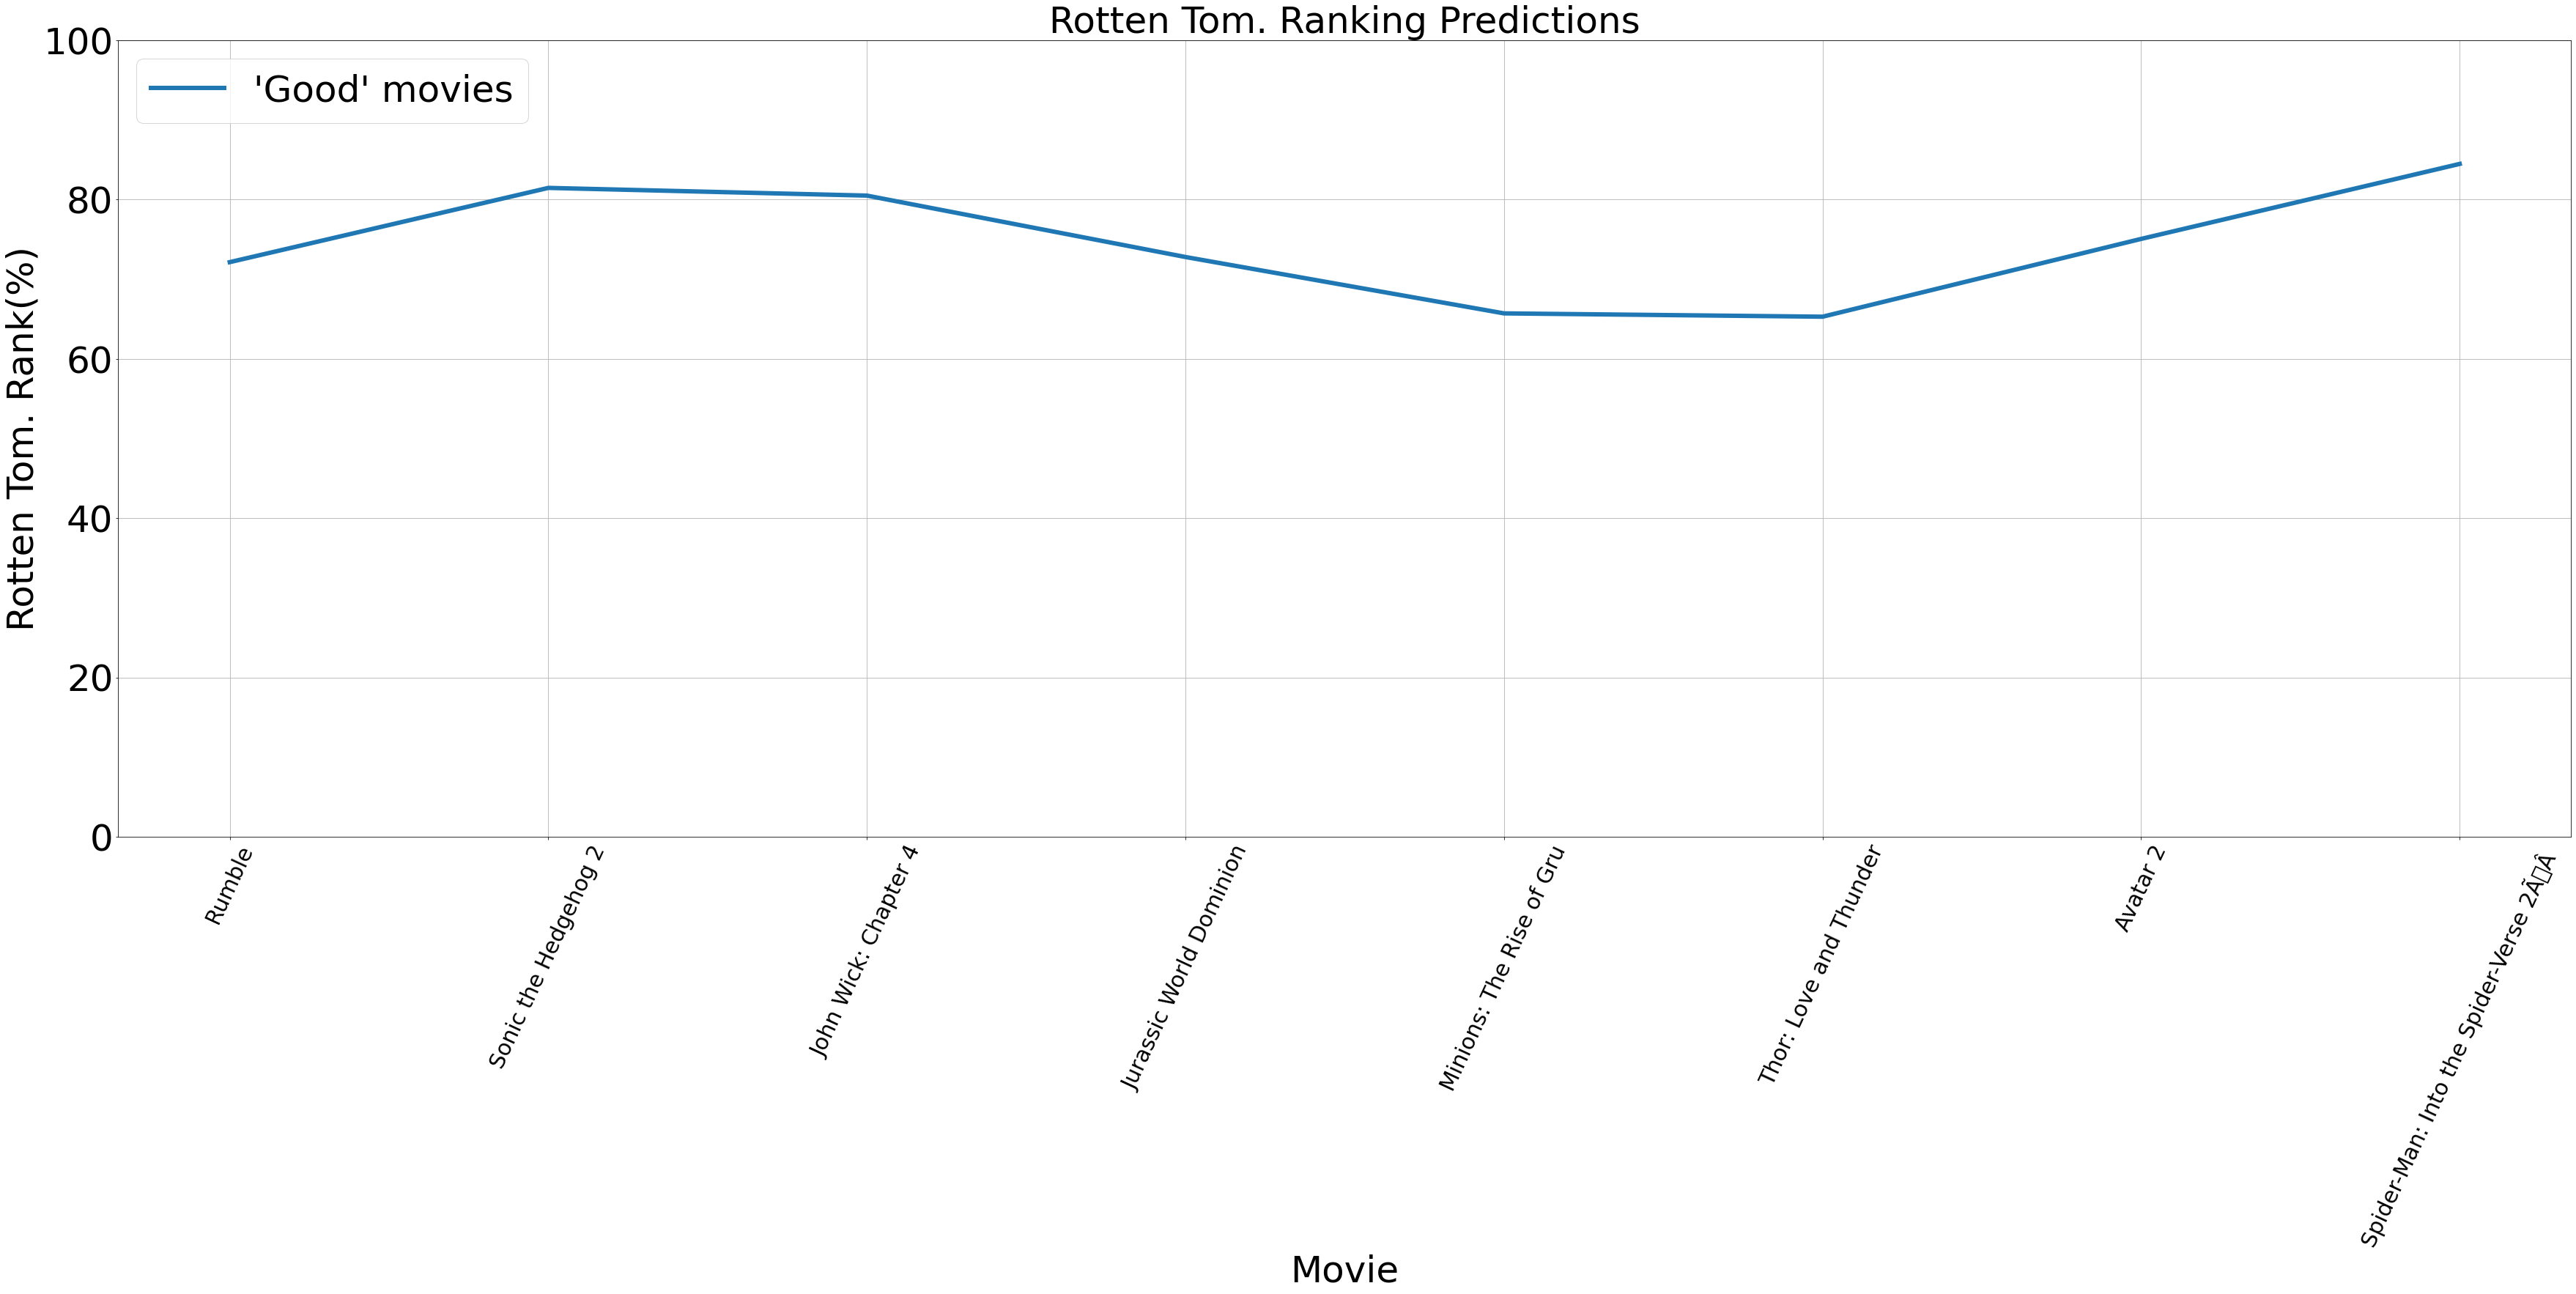

/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ella/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 147 missing from

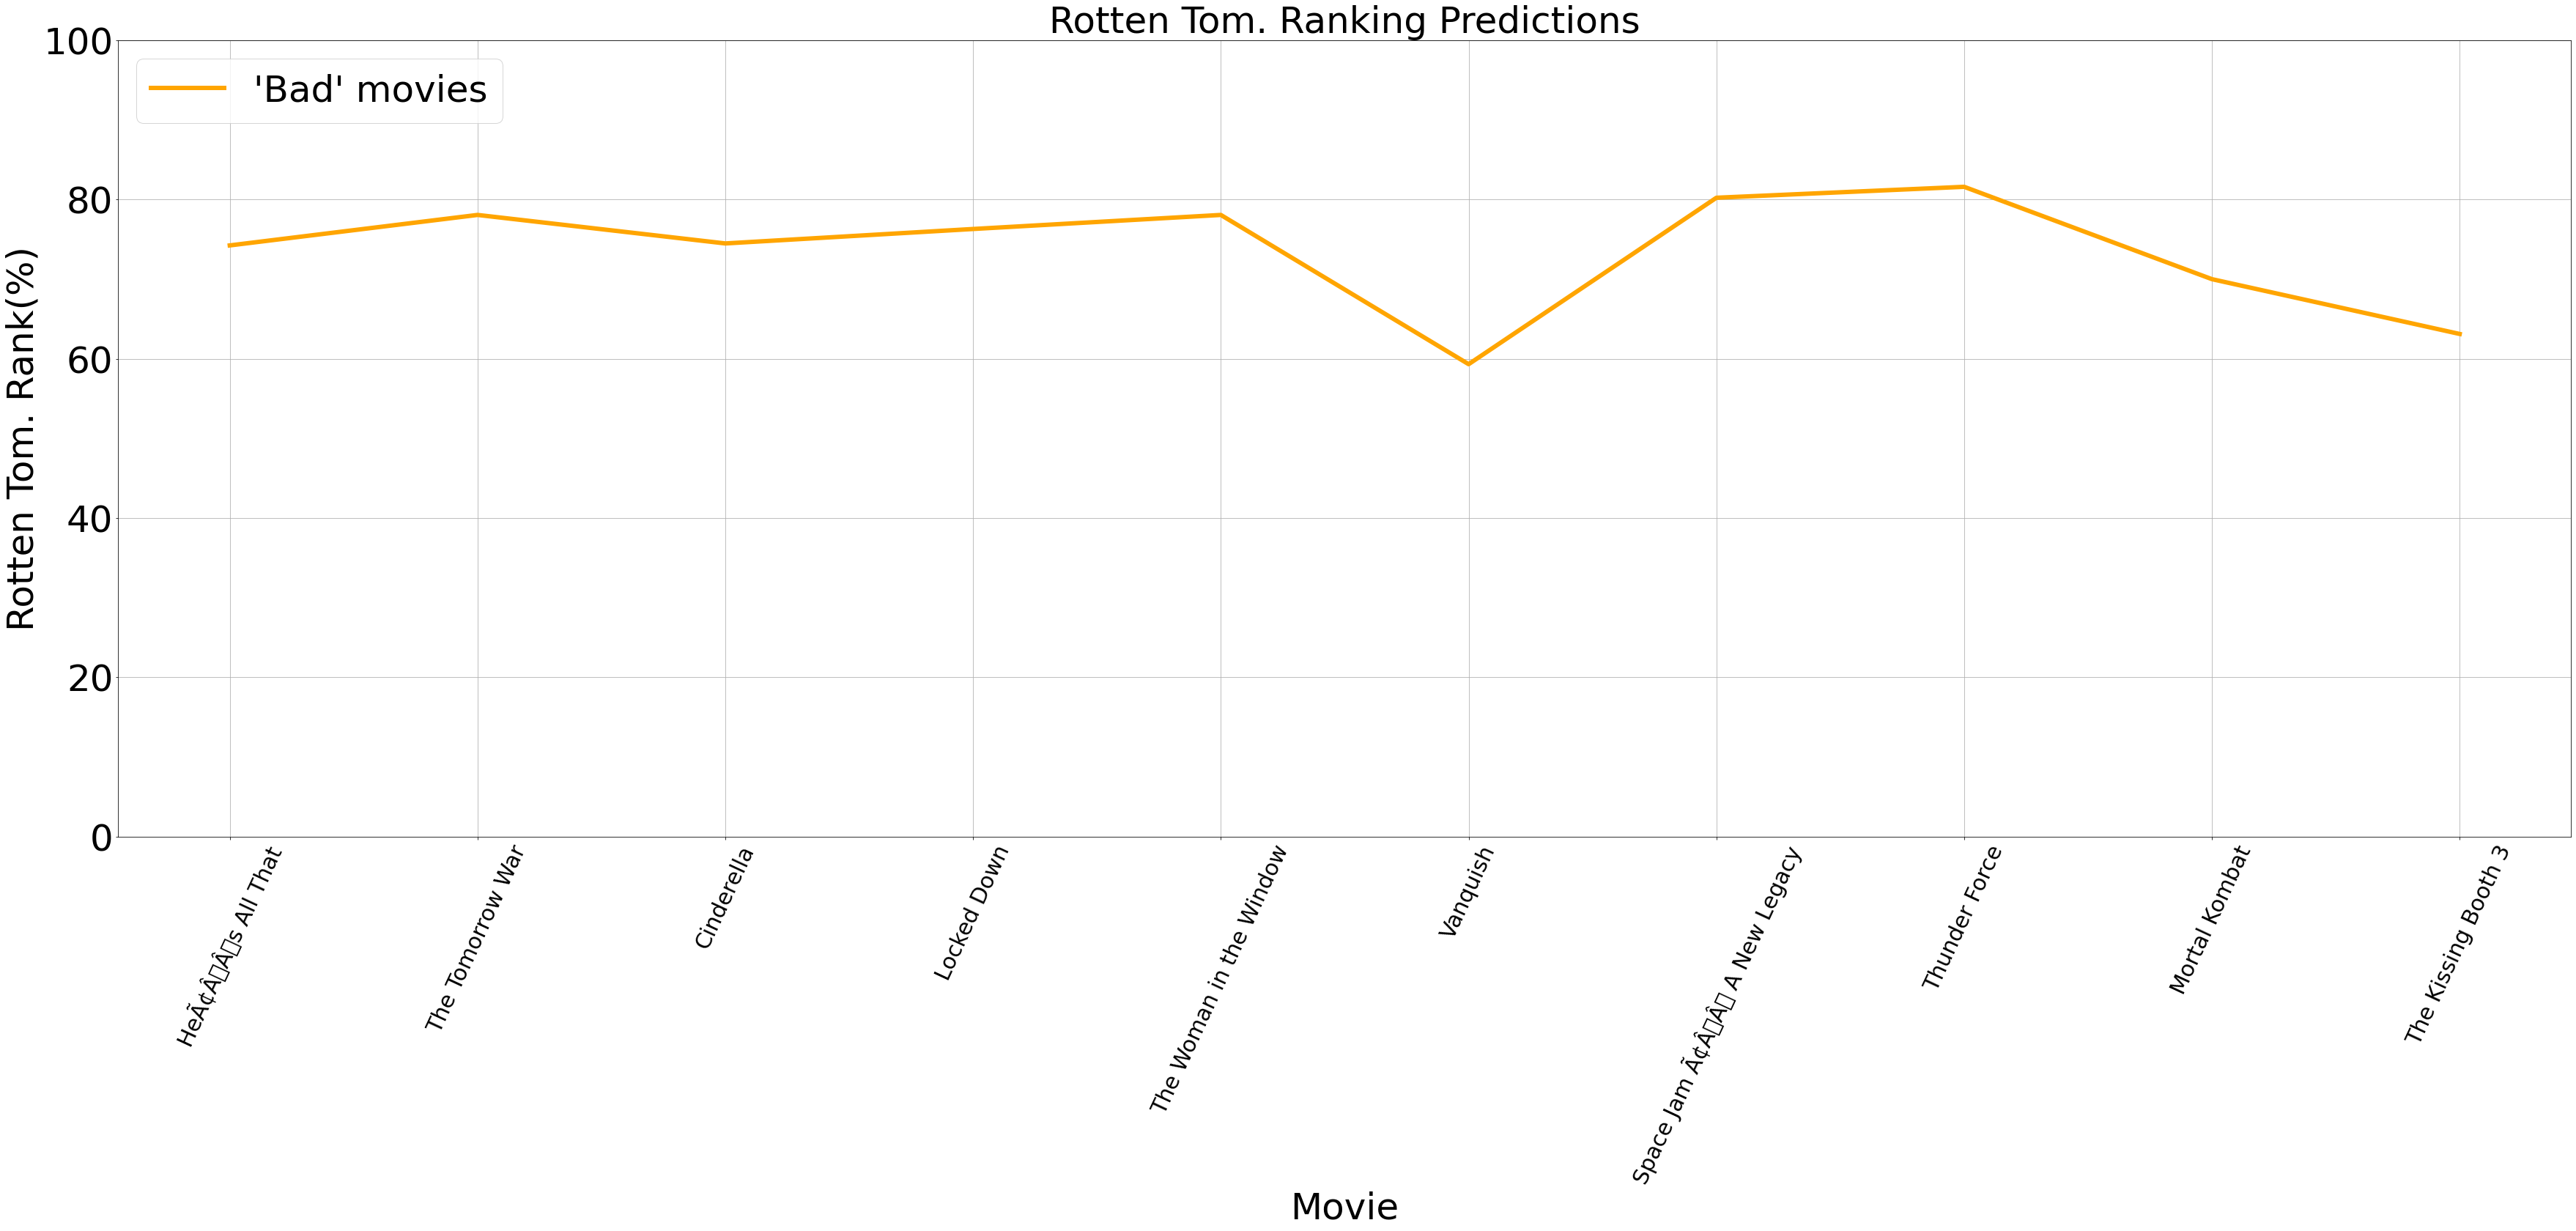

In [32]:
# plot lines
f = plt.figure()
f.set_figwidth(60)
f.set_figheight(20)

plt.plot(good_predictions_title_lst, good_predictions_lst, label = "'Good' movies",linewidth=6)
plt.legend(loc=2,prop={'size': 50})
plt.title('Rotten Tom. Ranking Predictions',fontsize=50)
plt.xlabel('Movie',fontsize=50)
plt.ylabel('Rotten Tom. Rank(%)',fontsize=50)
plt.xticks(fontsize=30,rotation=65)
plt.yticks(fontsize=50)
plt.ylim([0, 100])
plt.grid()
plt.show()

# plot lines
f = plt.figure()
f.set_figwidth(60)
f.set_figheight(20)

plt.plot(bad_predictions_title_lst, bad_predictions_lst, label = "'Bad' movies",linewidth=6,color='orange')
plt.legend(loc=2,prop={'size': 50})
plt.title('Rotten Tom. Ranking Predictions',fontsize=50)
plt.xlabel('Movie',fontsize=50)
plt.ylabel('Rotten Tom. Rank(%)',fontsize=50)
plt.xticks(fontsize=30,rotation=65)
plt.yticks(fontsize=50)
plt.ylim([0, 100])
plt.grid()
plt.show()

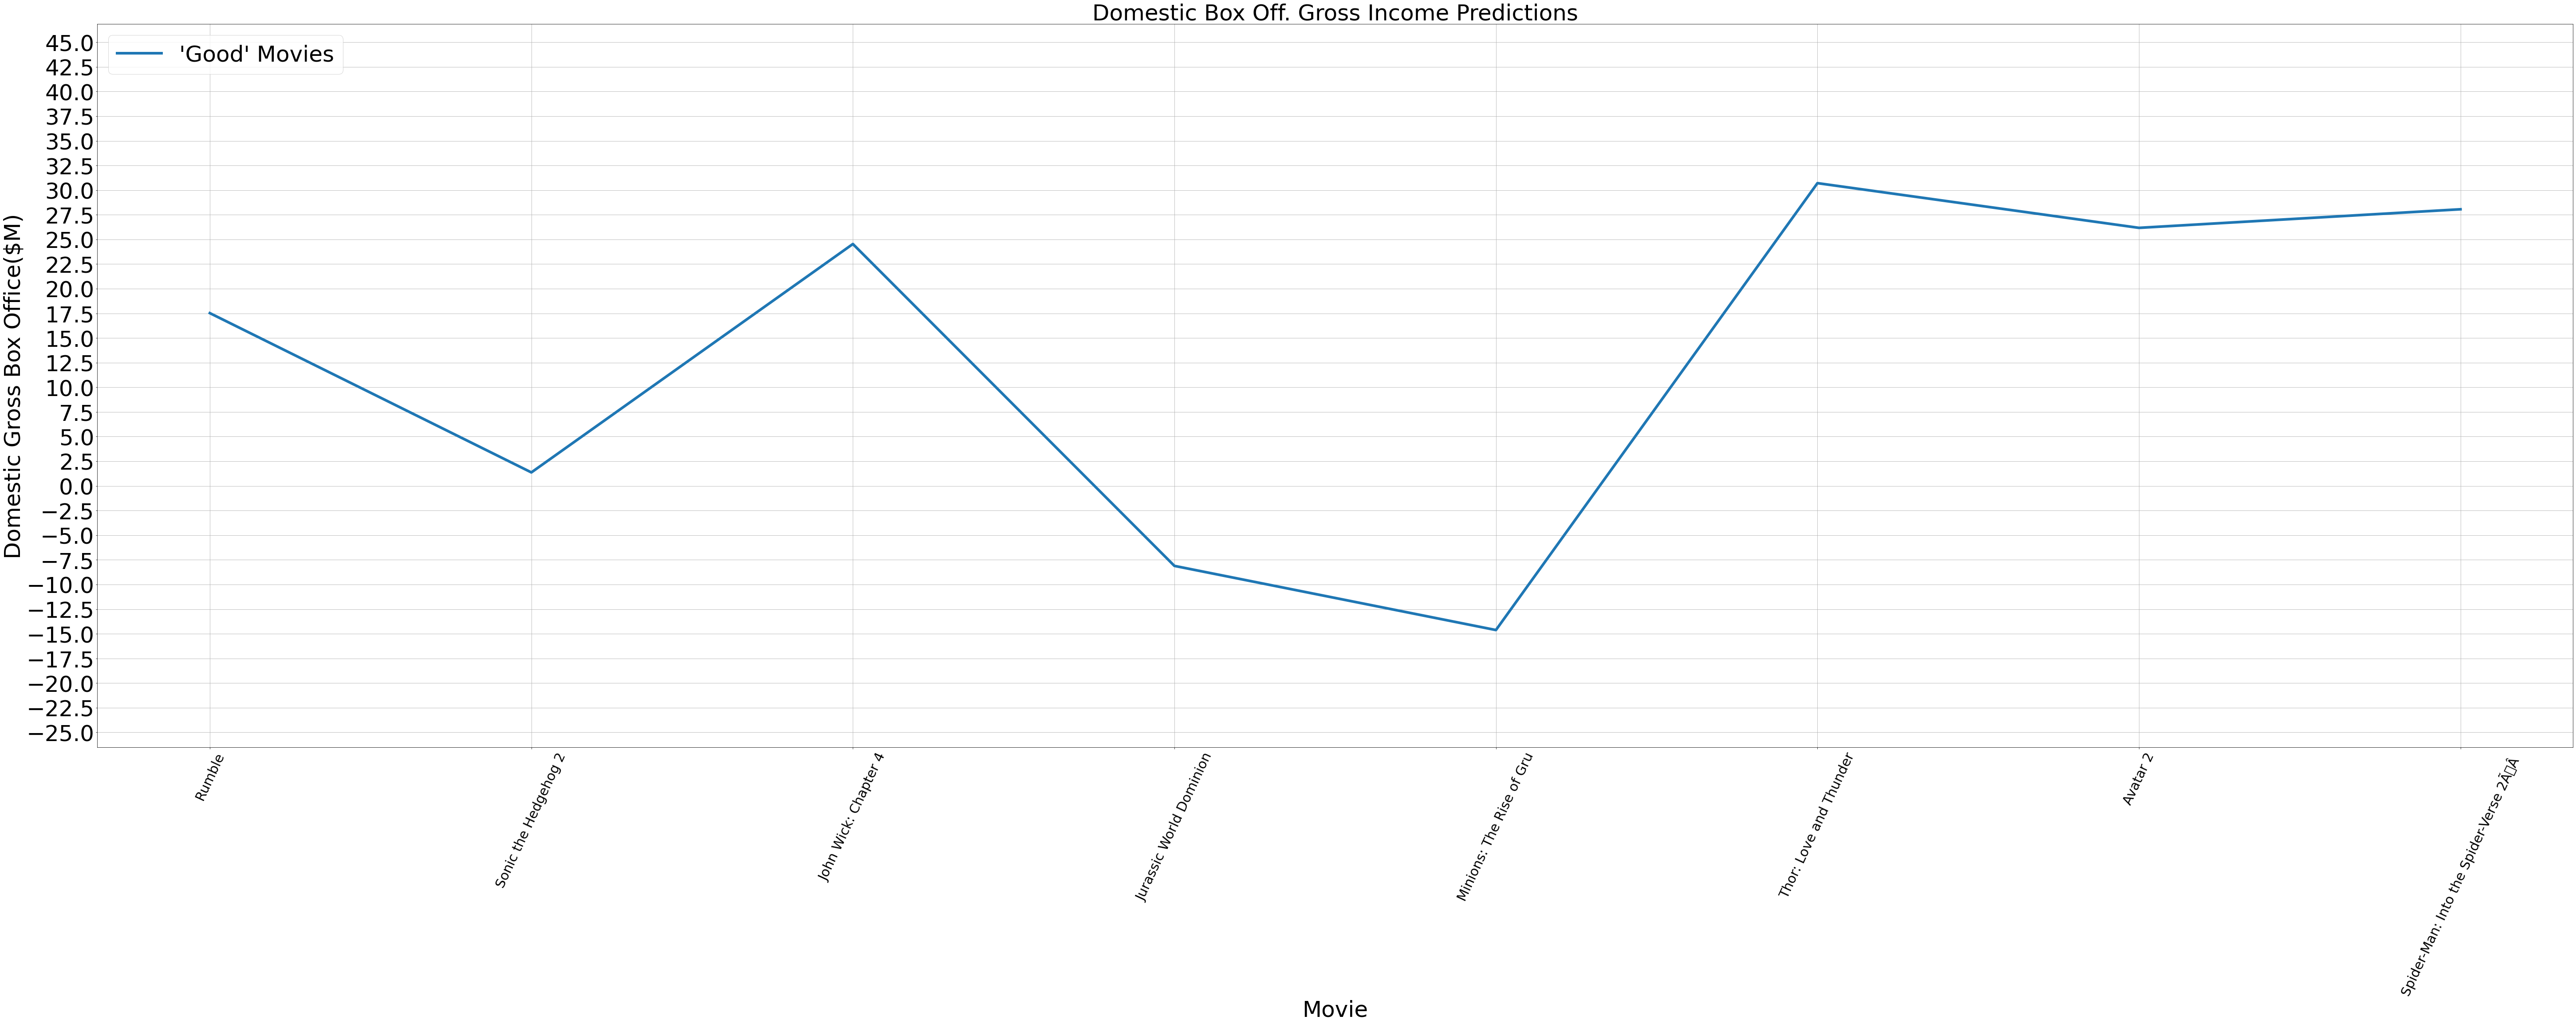

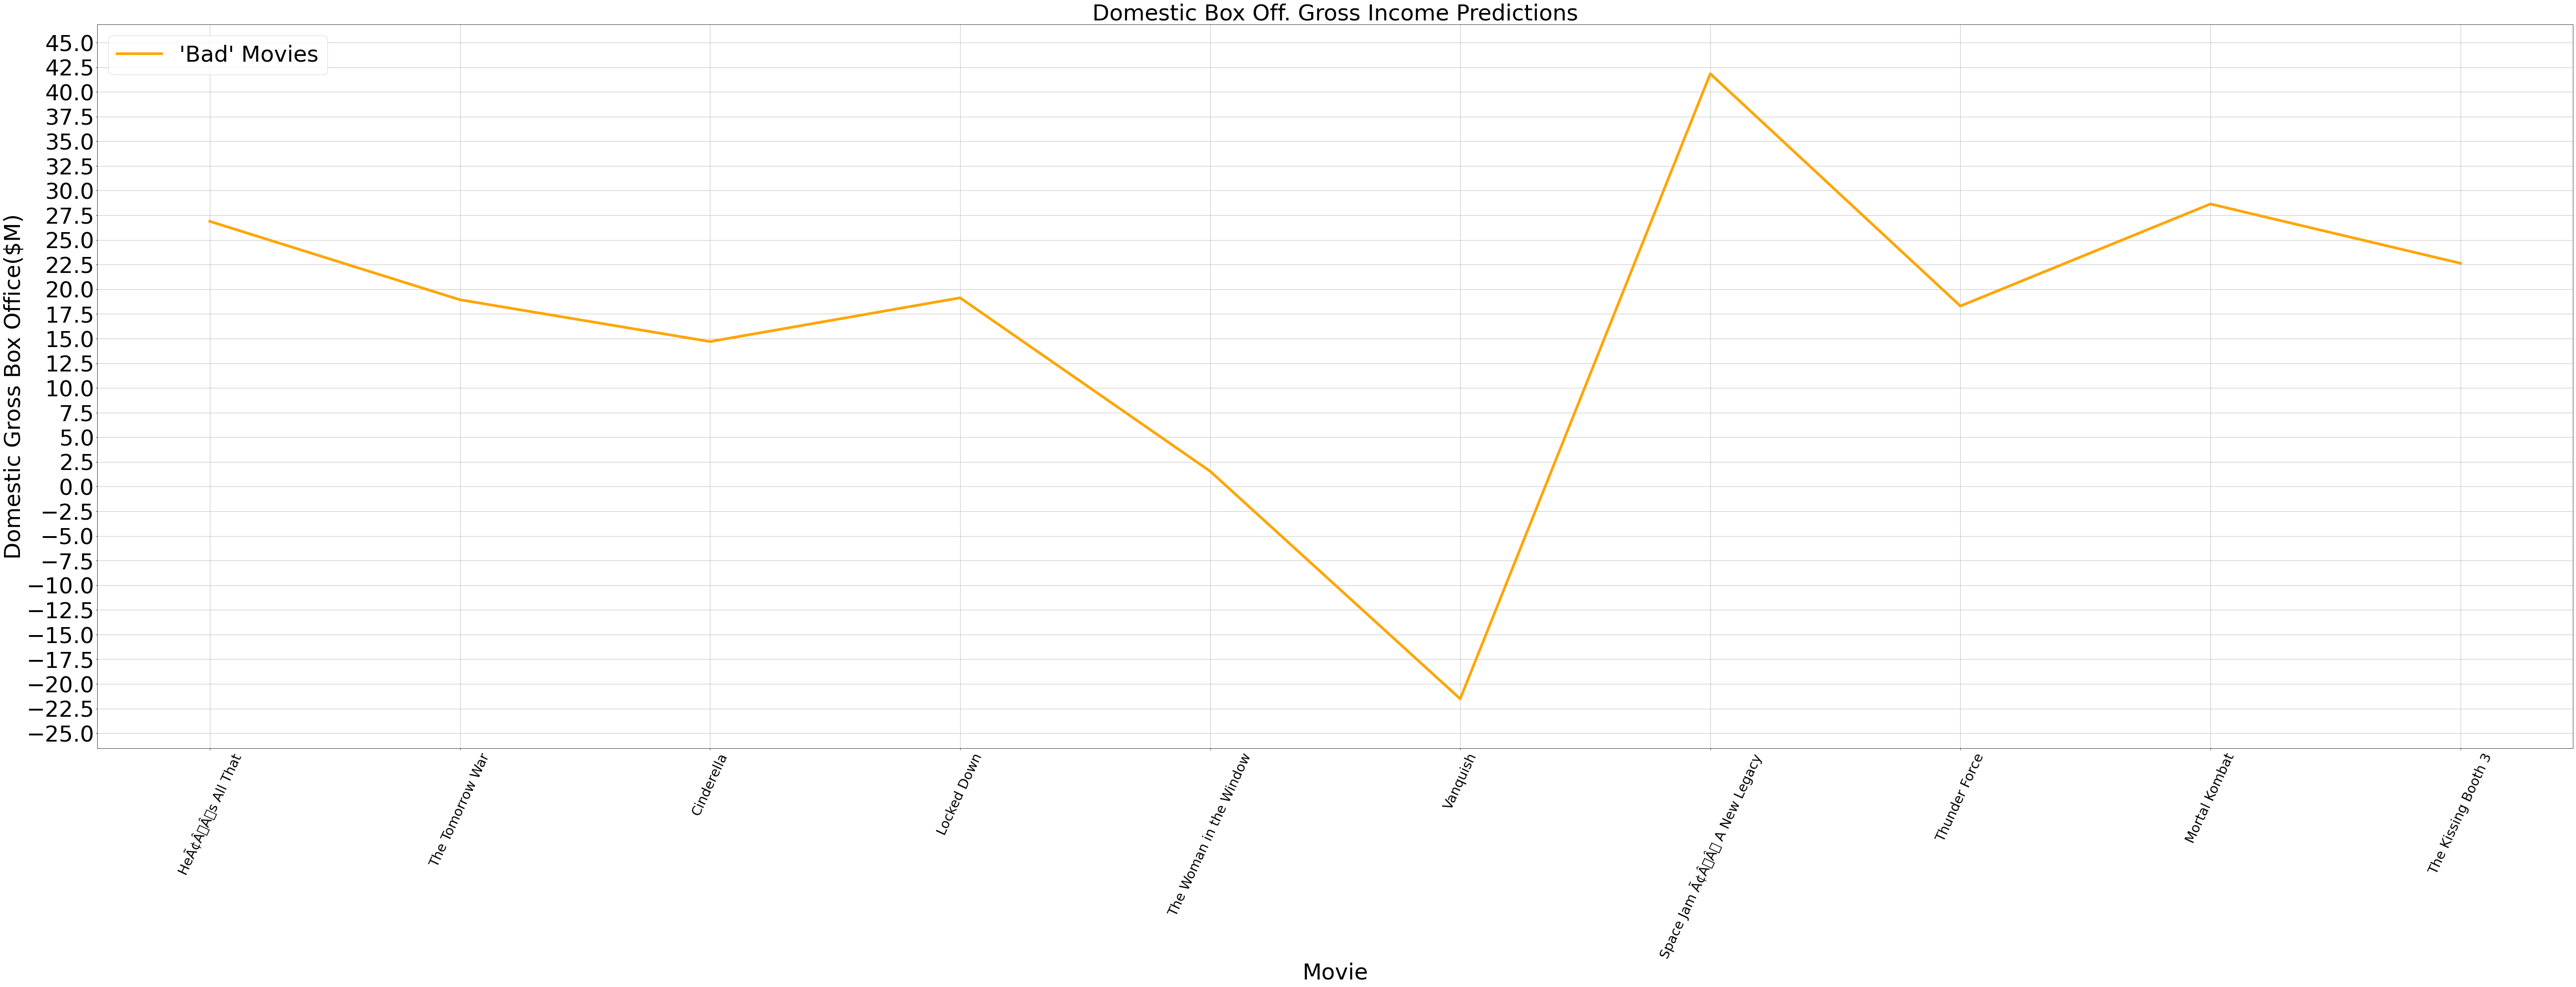

In [33]:
# plot lines
f = plt.figure()
f.set_figwidth(100)
f.set_figheight(30)

max_val=max([max(good_pred_lst2),max(bad_pred_lst2)])+5
min_val=min([min(good_pred_lst2),min(bad_pred_lst2)])-5

plt.plot(good_title_lst2, good_pred_lst2, label = "'Good' Movies",linewidth=6)
plt.legend(loc=2,prop={'size': 50})
plt.title('Domestic Box Off. Gross Income Predictions',fontsize=50)
plt.xlabel('Movie',fontsize=50)
plt.ylabel('Domestic Gross Box Office($M)',fontsize=50)
plt.xticks(fontsize=30,rotation=65)
plt.yticks(fontsize=50)
plt.ylim([min_val, max_val])
plt.grid()
plt.locator_params(tight=True,axis="y", nbins=30)
plt.show()

# plot lines
f = plt.figure()
f.set_figwidth(100)
f.set_figheight(30)

plt.plot(bad_title_lst2, bad_pred_lst2, label = "'Bad' Movies",linewidth=6,color='orange')
plt.legend(loc=2,prop={'size': 50})
plt.title('Domestic Box Off. Gross Income Predictions',fontsize=50)
plt.xlabel('Movie',fontsize=50)
plt.ylabel('Domestic Gross Box Office($M)',fontsize=50)
plt.xticks(fontsize=30,rotation=65)
plt.yticks(fontsize=50)
plt.ylim([min_val, max_val])
plt.grid()
plt.locator_params(tight=True,axis="y", nbins=30)
plt.show()


## Step 15: Select Best/Worst Performing Movies of 2021, and 2022 (Expected bad Expected Good)

In [34]:
n=0
sort_Rating=testData1.orderBy("label")
sort_Rating.show(30)
sort_feat=sort_Rating.select('features').collect()
sort_title=sort_Rating.select('title').collect()

min_feat=sort_feat[0][0]
min_title=sort_title[0][0]

max_feat=sort_feat[len(sort_feat)-1][0]
max_title=sort_title[len(sort_title)-1][0]

+-----+--------------------+--------------------+-------+---------+
|label|            features|               Title|lengths|   DomBox|
+-----+--------------------+--------------------+-------+---------+
| 30.0|[4.0,-3.0,2.0,-2....|           Come Away|    500|   184477|
| 32.0|[-1.0,-2.0,2.0,1....| Shadow in the Cloud|    500|   156932|
| 39.0|[-1.0,3.0,3.0,2.0...|     Cut Throat City|    500|   855894|
| 43.0|[-1.0,1.0,2.0,-2....|               Tesla|    500|    93147|
| 51.0|[3.0,2.0,2.0,2.0,...|           The Lodge|    500|  2138907|
| 55.0|[-2.0,-2.0,1.0,-4...|               Alone|    500|   538358|
| 55.0|[2.0,3.0,2.0,2.0,...|The Personal Hist...|    500|  1876298|
| 56.0|[3.0,-3.0,3.0,3.0...|     The New Mutants|    500| 23855569|
| 60.0|[-4.0,2.0,-2.0,-2...|      The Photograph|    500| 20578185|
| 60.0|[1.0,-2.0,3.0,3.0...|            Downhill|    500|  8287061|
| 66.0|[-3.0,3.0,4.0,3.0...|Bill & Ted Face t...|    500|  3439660|
| 69.0|[-3.0,-3.0,-3.0,1...|            Infamous

In [35]:
sort_GPRE=good_predictions.orderBy("prediction")
sort_GPRE.show(30)
sort_Gfeat=sort_GPRE.select('features').collect()
sort_Gtitle=sort_GPRE.select('title').collect()

min_Gfeat=sort_Gfeat[0][0]
min_Gtitle=sort_Gtitle[0][0]
max_Gfeat=sort_Gfeat[len(sort_Gfeat)-1][0]
max_Gtitle=sort_Gtitle[len(sort_Gtitle)-1][0]

sort_BPRE=bad_predictions.orderBy("prediction")
sort_BPRE.show(30)
sort_Bfeat=sort_BPRE.select('features').collect()
sort_Btitle=sort_BPRE.select('title').collect()

min_Bfeat=sort_Bfeat[0][0]
min_Btitle=sort_Btitle[0][0]
max_Bfeat=sort_Bfeat[len(sort_Bfeat)-1][0]
max_Btitle=sort_Btitle[len(sort_Btitle)-1][0]

+--------------------+--------------------+-------+-----------------+
|            features|               Title|lengths|       prediction|
+--------------------+--------------------+-------+-----------------+
|[3.0,4.0,3.0,1.0,...|Thor: Love and Th...|    500| 65.2928206365189|
|[1.0,3.0,-2.0,3.0...|Minions: The Rise...|    500|65.70957178826865|
|[4.0,2.0,-3.0,3.0...|              Rumble|    500|72.14208794105686|
|[-4.0,3.0,3.0,3.0...|Jurassic World Do...|    500|72.78654997472235|
|[1.0,-2.0,1.0,4.0...|            Avatar 2|    500|75.05863858612268|
|[3.0,3.0,4.0,2.0,...|John Wick: Chapter 4|    500|80.49488251997883|
|[3.0,2.0,3.0,-2.0...|Sonic the Hedgehog 2|    500|81.46185076356467|
|[2.0,3.0,-2.0,2.0...|Spider-Man: Into ...|    500| 84.4733950485766|
+--------------------+--------------------+-------+-----------------+

+--------------------+--------------------+-------+-----------------+
|            features|               Title|lengths|       prediction|
+------------------

## Step 16: Calculate number of word Ranking occurances for each respective DF

In [36]:
n=-5
min_occur=[]
max_occur=[]
Gmin_occur=[]
Gmax_occur=[]
Bmin_occur=[]
Bmax_occur=[]

rank_valueX=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

while n<=5:
    min_occur.append(min_feat.tolist().count(n))
    max_occur.append(max_feat.tolist().count(n))
    Gmin_occur.append(min_Gfeat.tolist().count(n))
    Gmax_occur.append(max_Gfeat.tolist().count(n))
    Bmin_occur.append(min_Bfeat.tolist().count(n))
    Bmax_occur.append(max_Bfeat.tolist().count(n))
    n=n+1
    
print(min_occur)
print(max_occur)
print(Gmin_occur)
print(Gmax_occur)
print(Bmin_occur)
print(Bmax_occur)

[0, 13, 54, 73, 43, 0, 62, 105, 108, 41, 1]
[0, 15, 59, 80, 40, 1, 91, 100, 84, 28, 2]
[0, 8, 33, 43, 44, 0, 77, 130, 132, 33, 0]
[0, 7, 5, 27, 26, 0, 29, 114, 196, 95, 1]
[1, 18, 90, 64, 73, 1, 63, 119, 53, 18, 0]
[0, 7, 23, 40, 26, 0, 76, 124, 155, 49, 0]


## Plot Occurance Graphs for 2021, 2022(Expected Good) and 2022 (Expected Bad) Movies

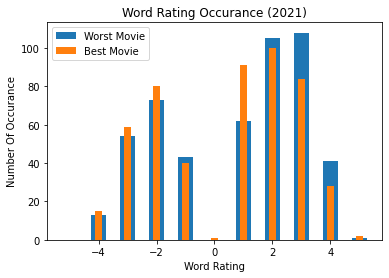

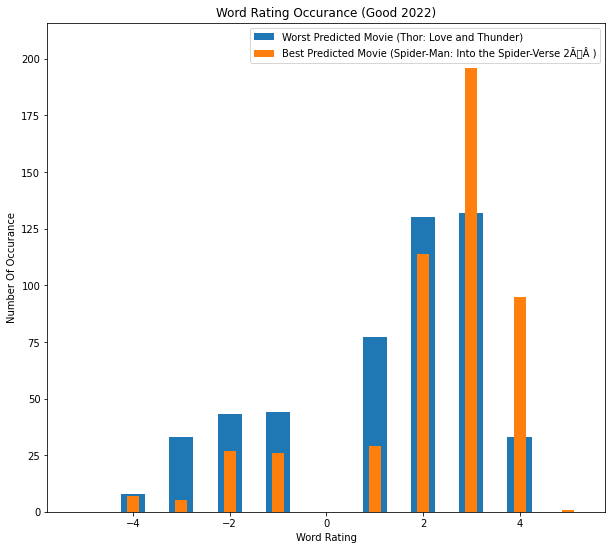

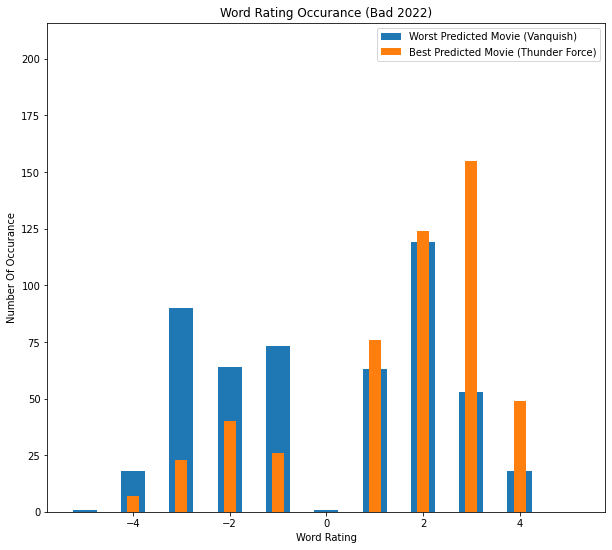

In [37]:
max_val=max([max(Gmax_occur),max(Bmax_occur),max(Gmin_occur),max(Bmin_occur)])+20
 
# plotting a bar chart
plt.bar(rank_valueX, min_occur,
        width = 0.5, label='Worst Movie' )
plt.bar(rank_valueX, max_occur,
        width = .25, label='Best Movie')
 
# naming the x-axis
plt.xlabel('Word Rating')
# naming the y-axis
plt.ylabel('Number Of Occurance')
# plot title
plt.title('Word Rating Occurance (2021)')
plt.legend()
 
# function to show the plot
plt.show()
 
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(9)
    
# plotting a bar chart
plt.bar(rank_valueX, Gmin_occur,
        width = 0.5, label='Worst Predicted Movie (' + min_Gtitle+')')
plt.bar(rank_valueX, Gmax_occur,
        width = .25, label='Best Predicted Movie (' + max_Gtitle+')')
 
# naming the x-axis
plt.xlabel('Word Rating')
# naming the y-axis
plt.ylabel('Number Of Occurance')
# plot title
plt.title('Word Rating Occurance (Good 2022)')
plt.legend()
plt.ylim([0, max_val])
 
# function to show the plot
plt.show()

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(9)
 
# plotting a bar chart
plt.bar(rank_valueX, Bmin_occur,
        width = 0.5, label='Worst Predicted Movie (' + min_Btitle+')')
plt.bar(rank_valueX, Bmax_occur,
        width = .25, label='Best Predicted Movie (' + max_Btitle+')')
 
# naming the x-axis
plt.xlabel('Word Rating')
# naming the y-axis
plt.ylabel('Number Of Occurance')
# plot title
plt.title('Word Rating Occurance (Bad 2022)')
plt.legend()
plt.ylim([0, max_val])
 
# function to show the plot
plt.show()